# Classification tree

For starters we'll work on a classification tree. For this we'll work using the breast cancer dataset available within the sklearn datasets, and later on we'll try it on a different dataset

In [1]:
import numpy as np
from collections import Counter
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
# let's define our class Node, which will have the basic charasteristics of a Node
class el_Nodo:
  # class Node
    def __init__(self, feature=None, threshold=None, left_branch=None, right_branch=None,*,value=None):
      
      # the node has the selection of the feature
      self.feature = feature
      # the threshold that we are using to check if the branch is going to go left or right
      self.threshold = threshold
      # the left branch
      self.left_branch = left_branch
      # the right branch
      self.right_branch = right_branch
      # the value of the node
      self.value = value
        
    def es_hoja(self):
      # is_leaf_node(self):
      return self.value is not None

In [3]:
class Classification_tree:
  # this class is defined to execute the classification tree perse
  # for it we'll take into consideration 2 samples as the minimum required to make a split
  # and a max depth of 100
  def __init__(self, min_samples_for_split=2, max_depth=100):
      self.min_samples_for_split=min_samples_for_split
      self.max_depth=max_depth
      self.num_features=None
      self.root=None

  def fit(self, X, y):# here is where the fit 
  # we define the number of features as the entry of the data
  # the data that it receives is supposed to come as an array of arrays
  # where the first entry gives the number of rows, and the second the number of features "columns"
    self.num_features = X.shape[1]
    # we call the create tree funtion
    self.root = self.create_tree(X, y)

  def create_tree(self, X, y, depth=0):
  # def _grow_tree(self, X, y, depth=0):
  # this is the main function in charge of creating the tree
      n_samples, n_feats = X.shape
      # since this is a classification tree, we want to have the unique amount of labels of the response variable
      # by that we mean that if we have a response variable with values 0 1 2 2 3 4, the n_labels will only have the value of 5 which
      # corresponds to the unique values of the response variable 0 1 2 3 4
      n_labels = len(np.unique(y))

      # this is the stopping criteria, that of the current depth of the tree is greater or equal than 
      # the maximal depth of the tree it breaks
      # also breaks if the response variable only has one value
      # also braks if the number od samples is less than the minimal amount of samples that are 
      # required to make a split
      if (depth>=self.max_depth or n_labels==1 or n_samples<self.min_samples_for_split):
          # leaf_value = self.popular_label(y)
          # then the value of the leaf is going to take the label that is more popular
          valor_de_hoja = self.popular_label(y)
          return el_Nodo(value=valor_de_hoja)
      # order in a random way the indixes of the features
      feat_idxs = np.random.choice(n_feats, self.num_features, replace=False)

      # call the best split function
      best_feature, best_thresh = self.get_best_split(X, y, feat_idxs)

      # create child nodes
      left_idxs, right_idxs = self.the_split(X[:, best_feature], best_thresh)
      # call recursively the create tree function
      left = self.create_tree(X[left_idxs, :], y[left_idxs], depth+1)
      right = self.create_tree(X[right_idxs, :], y[right_idxs], depth+1)
      return el_Nodo(best_feature, best_thresh, left, right)


  def get_best_split(self, X, y, feat_indixes):
    # to find the best threshold out of all the ones available
      best_gain = -1# initialize the best gain
      split_idx, split_threshold = None, None#initialize the split index and threshold
      # iterate through the indixes of the features
      for feat_idx in feat_indixes:
          X_column = X[:, feat_idx]#extract the values of the features
          thresholds = np.unique(X_column)

          for thr in thresholds:
              # calculate the information gain
              gain = self.information_gain(y, X_column, thr)

              if gain > best_gain:
                  best_gain = gain
                  split_idx = feat_idx
                  split_threshold = thr

      return split_idx, split_threshold


  def information_gain(self, y, X_column, threshold):
    # this is the entropy of the parent-weighted average*entropy of the children
      # parent entropy
      parent_entropy = self.calculate_entropy(y)

      # create children
      left_idxs, right_idxs = self.the_split(X_column, threshold)
      # if the left indixes has nothing or the right one has nothing
      if len(left_idxs) == 0 or len(right_idxs) == 0:
          return 0#then the info gain is 0
      
      # calculate the weighted avg. entropy of children
      # samples in y
      n = len(y)
      # samples in left and right
      n_l, n_r = len(left_idxs), len(right_idxs)
      # entropy from the left and the right
      e_l, e_r = self.calculate_entropy(y[left_idxs]), self.calculate_entropy(y[right_idxs])
      child_entropy = (n_l/n) * e_l + (n_r/n) * e_r

      # calculate the information gain
      information_gain = parent_entropy - child_entropy
      return information_gain

  def the_split(self, X_column, split_thresh):
    # this is going to give us the indixes in the column that contain values that follow
    # if the value es less or equal than the threshold go to left
      left_idxs = np.argwhere(X_column <= split_thresh).flatten()
      # otherwise go to right
      right_idxs = np.argwhere(X_column > split_thresh).flatten()
      return left_idxs, right_idxs

  def calculate_entropy(self, y):
    # the entropy is calculated as
    # entropy=-sum p(X)*log(p(X)) where p(X)=#x/n
    # ocurrencies is going to have the amount of times that each of the elements of y
    # has appeared in y
      ocurrencies = np.bincount(y)
      p_x = ocurrencies / len(y)
      return -np.sum([p * np.log(p) for p in p_x if p>0])
  

  def popular_label(self, y):
      counter = Counter(y)
      # this is to extract the most repeated label in y
      popular = counter.most_common(1)[0][0]
      return popular

  def predict(self, X):
      return np.array([self.level_of_tree(x, self.root) for x in X])

  def level_of_tree(self, x, node):
    # if the node is a leaf, then we pass its value
      if node.es_hoja():
          return node.value
    # it the node is not a leaf, then we want to check 
    # if the value of x a the feature that is getting divided with is less than the threshold
      if x[node.feature] <= node.threshold:
          return self.level_of_tree(x, node.left_branch)
      return self.level_of_tree(x, node.right_branch)

In [4]:
lb_can = datasets.load_breast_cancer()
X, y = lb_can.data, lb_can.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1296
)

my_tree = Classification_tree(max_depth=10)
my_tree.fit(X_train, y_train)
predictions = my_tree.predict(X_test)

def accuracy(testing_y, predicted_y):
    return np.sum(testing_y == predicted_y) / len(testing_y)

acc = accuracy(y_test, predictions)
print(acc)

0.9385964912280702


In [5]:
from sklearn.datasets import load_iris
iris = load_iris()
x = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=666666)

my_tree = Classification_tree(max_depth=10)
my_tree.fit(X_train, y_train)
predictions = my_tree.predict(X_test)

def accuracy(testing_y, predicted_y):
    return np.sum(testing_y == predicted_y) / len(testing_y)

acc = accuracy(y_test, predictions)
print(acc)

0.9333333333333333


# Comparing with the Decision Tree Classifier
Now we'll compare how our tre performs against the package from python

In [6]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

In [7]:
pyton_tree = DecisionTreeClassifier(criterion="entropy",max_depth=10)
pyton_tree.fit(X_train,y_train)
y_test_pred = pyton_tree.predict(X_test)

acc_python=accuracy(y_test,y_test_pred)
print(acc_python)
# for this one it gives a better result.....let's compare to a bunch of parameters

0.9


In [10]:
from sklearn.model_selection import train_test_split

In [15]:
max_depth=range(5,15)

my_accuracies=[]
scik_accuracies=[]
X, y = lb_can.data, lb_can.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1296
)

In [16]:


for dep in max_depth:
  
  my_tree = Classification_tree(max_depth=dep)
  my_tree.fit(X_train, y_train)
  my_predictions = my_tree.predict(X_test)
  acc = accuracy(y_test, my_predictions)
  my_accuracies.append(acc)

  pyton_tree = DecisionTreeClassifier(criterion="entropy",max_depth=dep)
  pyton_tree.fit(X_train,y_train)
  y_test_pred = pyton_tree.predict(X_test)
  acc=accuracy(y_test,y_test_pred)

  scik_accuracies.append(acc)
# plt.figure()
# plt.plot(max_depth, my_accuracies, label = "my_accuracies")
# plt.plot(max_depth, scik_accuracies, label = "sklearn_accuracies")
# # plt.legend()
# plt.show()




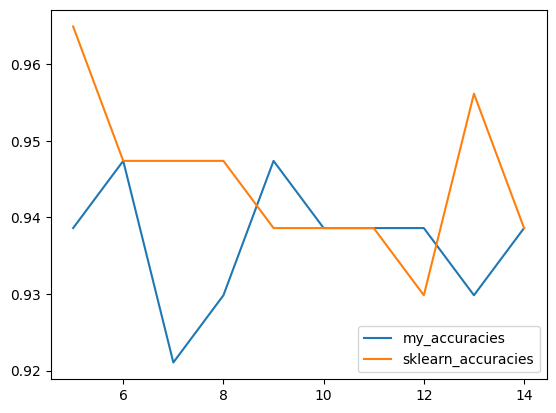

In [17]:
plt.figure()
plt.plot(max_depth, my_accuracies, label = "my_accuracies")
plt.plot(max_depth, scik_accuracies, label = "sklearn_accuracies")
plt.legend(loc='lower right')
plt.show()
# in this ugly AF, but useful chart, we can see some fluctuations on accuracy
# between the classification process that we defined vs
# the one given by sklearn, with some meetpoints
# however, our method performs poorlier tha sklearn :(

In [ ]:
# in this ugly AF, but useful chart, we can see some fluctuations on accuracy
# between the classification process that we defined vs
# the one given by sklearn, with some meetpoints
# however, our method performs poorlier tha sklearn :(

In [18]:
print(my_accuracies)


[0.9385964912280702, 0.9473684210526315, 0.9210526315789473, 0.9298245614035088, 0.9473684210526315, 0.9385964912280702, 0.9385964912280702, 0.9385964912280702, 0.9298245614035088, 0.9385964912280702]


In [19]:
print(scik_accuracies)

[0.9649122807017544, 0.9473684210526315, 0.9473684210526315, 0.9473684210526315, 0.9385964912280702, 0.9385964912280702, 0.9385964912280702, 0.9298245614035088, 0.956140350877193, 0.9385964912280702]


# Regression Tree

In [20]:
import numpy as np
from collections import Counter
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.datasets import load_diabetes

In [21]:
# let's define our class Node, which will have the basic charasteristics of a Node
class el_Nodo:
  # class Node
    def __init__(self, feature=None, threshold=None, left_branch=None, right_branch=None, var_red=None, value=None):
     
      # the node has the selection of the feature
      self.feature = feature
      # the threshold that we are using to check if the branch is going to go left or right
      self.threshold = threshold
      # the left branch
      self.left_branch = left_branch
      # the right branch
      self.right_branch = right_branch
      self.var_red = var_red

      # the value of the node
      self.value = value
        
    # def es_hoja(self):
    #   # is_leaf_node(self):
    #   return self.value is not None

In [22]:
class El_Regression_tree:
  # this class is defined to execute the classification tree perse
  # for it we'll take into consideration 2 samples as the minimum required to make a split
  # and a max depth of 100
  def __init__(self, min_samples_for_split=2, max_depth=100):
      self.min_samples_for_split=min_samples_for_split
      self.max_depth=max_depth
      self.num_features=None
      self.root=None

  def fit(self, X, y):# here is where the fit 
  # we define the number of features as the entry of the data
  # the data that it receives is supposed to come as an array of arrays
  # where the first entry gives the number of rows, and the second the number of features "columns"
    self.num_features = X.shape[1]
    # we call the create tree funtion
    self.root = self.create_tree(X, y)

  def create_tree(self, X, y, depth=0):
  # def _grow_tree(self, X, y, depth=0):
  # this is the main function in charge of creating the tree
    n_samples, n_feats = X.shape
    
    if (depth>=self.max_depth or n_samples<self.min_samples_for_split):
        # leaf_value = self.popular_label(y)
        # then the value of the leaf is going to take the label that is more popular
        valor_de_hoja = self.popular_label(y)
        return el_Nodo(value=valor_de_hoja)
    # order in a random way the indixes of the features
    # feat_idxs = np.random.choice(n_feats, self.num_features, replace=False)

    # call the best split function
    # best_feature, best_thresh = self.get_best_split(X, y, feat_idxs)
    mejor_split=self.get_best_split(X, y, n_feats)
    if mejor_split["var_red"]>0:
      left_idxs=mejor_split["indexes_left"]
      right_idxs=mejor_split["indexes_right"]
      left = self.create_tree(X[left_idxs, :], y[left_idxs], depth+1)
      right = self.create_tree(X[right_idxs, :], y[right_idxs], depth+1)
      return el_Nodo(mejor_split["feature_index"],mejor_split["threshold"],left,right,mejor_split["var_red"]) 

    valor_de_hoja = self.popular_label(y)
    return el_Nodo(value=valor_de_hoja)
    
      


  def get_best_split(self, X, y, feat_indixes):
    # to find the best threshold out of all the ones available
      max_var_red= -float("inf")# initialize the best gain
      # split_idx, split_threshold = None, None#initialize the split index and threshold
      # iterate through the indixes of the features
      best_split = {}

      for feature_index in range(feat_indixes):
        feature_values =X[:, feature_index]
        possible_thresholds = np.unique(feature_values)

        for threshold in possible_thresholds:
          indexes_left, indexes_right = self.the_split(feature_values, threshold)
          if len(indexes_left)>0 and len(indexes_right)>0:
            curr_var_red = self.variance_reduction(y, y[indexes_left],y[indexes_right])
            if curr_var_red>max_var_red:
              best_split["feature_index"] = feature_index
              best_split["threshold"] = threshold
              best_split["indexes_left"] = indexes_left
              best_split["indexes_right"] = indexes_right
              best_split["var_red"] = curr_var_red
              max_var_red = curr_var_red


      return best_split

 

  def the_split(self, X_column, split_thresh):
    # this is going to give us the indixes in the column that contain values that follow
    # if the value es less or equal than the threshold go to left
      left_idxs = np.argwhere(X_column <= split_thresh).flatten()
      # otherwise go to right
      right_idxs = np.argwhere(X_column > split_thresh).flatten()
      return left_idxs, right_idxs


  def variance_reduction(self, parent, l_child,r_child):
    weight_l = len(l_child) / len(parent)
    weight_r = len(r_child) / len(parent)
    reduction = np.var(parent) - (weight_l * np.var(l_child) + weight_r * np.var(r_child))
    return reduction
    

  def popular_label(self, y):
      media = np.mean(y)
      return media

  def predict(self, X):
      return np.array([self.level_of_tree(x, self.root) for x in X])

  def level_of_tree(self, x, node):
    # if the node is a leaf, then we pass its value
     
    if node.value!=None:
        return node.value

    if x[node.feature] <= node.threshold:
        return self.level_of_tree(x, node.left_branch)
    return self.level_of_tree(x, node.right_branch)

In [45]:
diabetes=load_diabetes()
X_train, X_test, y_train, y_test = train_test_split(diabetes.data, diabetes.target, test_size=0.20,random_state=129)
my_tree = El_Regression_tree(min_samples_for_split=2,max_depth=9)
my_tree.fit(X_train, y_train)
# predictions = my_tree.predict(X_test)

In [46]:
Y_pred = my_tree.predict(X_test) 
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_test, Y_pred))

75.95762288459157

# Comparing the Regression Tree

In [24]:
# let's test between a bunch of values
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

In [39]:
pyton_tree = DecisionTreeRegressor(max_depth=10)
pyton_tree.fit(X_train,y_train)
y_test_pred = pyton_tree.predict(X_test)

acc_python=np.sqrt(mean_squared_error(y_test, y_test_pred))
print(acc_python)

90.68606491691429


In [40]:
max_depth=range(5,16)

my_accuracies=[]
scik_accuracies=[]
X_train, X_test, y_train, y_test = train_test_split(
 diabetes.data, diabetes.target, test_size=0.2, random_state=1296
  )

In [47]:
for dep in max_depth:
  
  my_tree =El_Regression_tree(min_samples_for_split=2,max_depth=dep)
  my_tree.fit(X_train, y_train)
  my_predictions = my_tree.predict(X_test)
  acc =np.sqrt(mean_squared_error(y_test, my_predictions))
  my_accuracies.append(acc)

  pyton_tree = DecisionTreeRegressor(max_depth=dep)
  pyton_tree.fit(X_train,y_train)
  y_test_pred = pyton_tree.predict(X_test)
  acc=np.sqrt(mean_squared_error(y_test,y_test_pred))

  scik_accuracies.append(acc)

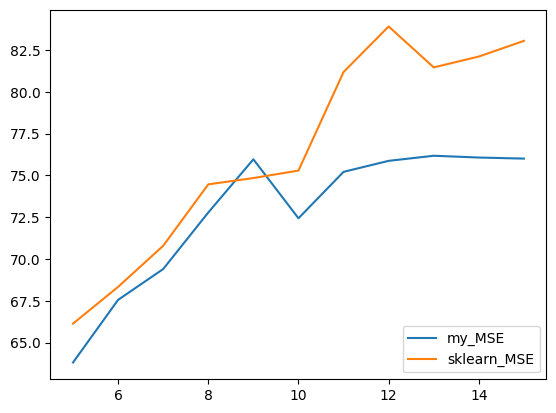

In [48]:
plt.figure()
plt.plot(max_depth, my_accuracies, label = "my_MSE")
plt.plot(max_depth, scik_accuracies, label = "sklearn_MSE")
plt.legend(loc='lower right')
plt.show()
# the lowest MSE is extracted when the depth is 5

In [49]:
# load data from sklearn
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn import model_selection
import matplotlib.pyplot as plt

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
result = raw_df.values[1::2, 2]

X_train, X_test, y_train, y_test= model_selection.train_test_split(data, result, test_size=0.3, random_state=66666)

In [50]:
def err(result, y):
    err = (result-y)**2
    return err.sum()

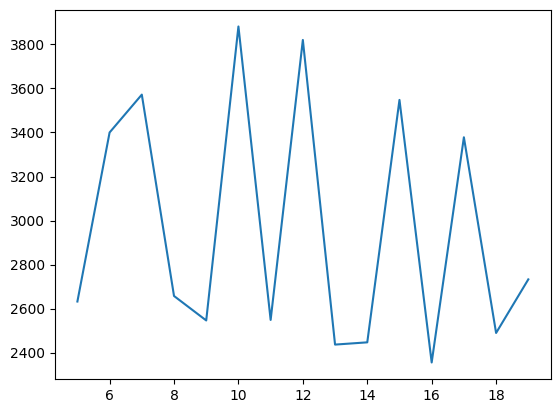

In [51]:
# con sklearn
errs =[]
for i in range(5,20):
    # tree = train(X_train,y_train,2,i)
    pyton_tree = DecisionTreeRegressor(max_depth=i)
    pyton_tree.fit(X_train,y_train)
    y_test_pred = pyton_tree.predict(X_test)
    errs.append(err(y_test_pred,y_test))
    # errs.append(err(predict(tree,X_test),y_test))

# plot the trend	
plt.plot(range(5,20),errs)

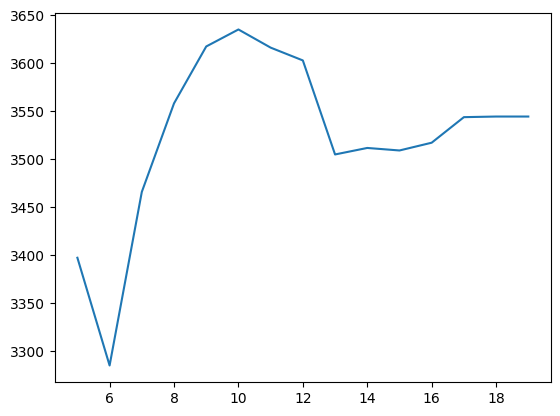

In [52]:
# mi código
errs =[]
for i in range(5,20):
    # tree = train(X_train,y_train,2,i)
    my_tree =El_Regression_tree(min_samples_for_split=2,max_depth=i)
    my_tree.fit(X_train, y_train)
    my_predictions = my_tree.predict(X_test)
    errs.append(err(my_predictions,y_test))
    # errs.append(err(predict(tree,X_test),y_test))

# plot the trend	
plt.plot(range(5,20),errs)